In [272]:
import yfinance as yf
import numpy as np
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

plt.rcParams['figure.figsize']=(16,8)
plt.style.use('ggplot')

In [273]:
# Importing data from yahoo finance
ticker = yf.Ticker("SQ")
data = ticker.history(period="max").drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

<h1> Use last year of data as test </h1>

In [274]:
trade_days = data.Close.count()

In [275]:
# Data, based on which we will make a prediction (Train data)
train_data = data.iloc[:(trade_days - 260)]

In [276]:
#Our test data, to compare in the end results
test_data = data.iloc[(trade_days - 260):]
# test_data = test_data.rename(columns={'Date': 'ds','Close': 'y'})

In [277]:
# Format train data in Prophet standards
prophet_data = train_data.reset_index().rename(columns={'Date': 'ds','Close': 'y'})

In [278]:
#Initialize prophit object
pr = Prophet()

In [279]:
pr.fit(prophet_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [280]:
#create future dataframe for 380 days
future = pr.make_future_dataframe(periods=380)

In [281]:
# Pandas function to remove all non business days from future df
isBusinessDay = BDay().onOffset

In [282]:
# Create a final future df without weekends
future_boolean = future['ds'].map(isBusinessDay)
future = future[future_boolean] 

In [283]:
#Make a prediction
forecast = pr.predict(future)

In [284]:
all_data = forecast.set_index('ds').join(train_data).tail(3000)

In [285]:
all_data.tail()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Close
ds,,,,,,,,,,,,,,,,,,,
2019-09-23,148.231071,125.985793,169.651112,126.085594,169.297884,0.319954,0.319954,0.319954,-1.092881,-1.092881,-1.092881,1.412835,1.412835,1.412835,0.0,0.0,0.0,148.551025,NaN
2019-09-24,148.407373,125.883009,170.168698,126.227151,169.561305,0.276674,0.276674,0.276674,-1.081955,-1.081955,-1.081955,1.358629,1.358629,1.358629,0.0,0.0,0.0,148.684047,NaN
2019-09-25,148.583675,126.005804,169.846297,126.251064,169.845902,0.294118,0.294118,0.294118,-1.032960,-1.032960,-1.032960,1.327078,1.327078,1.327078,0.0,0.0,0.0,148.877793,NaN
2019-09-26,148.759977,125.491889,170.220581,126.322230,170.092625,0.325028,0.325028,0.325028,-0.992938,-0.992938,-0.992938,1.317965,1.317965,1.317965,0.0,0.0,0.0,149.085005,NaN
2019-09-27,148.936279,125.739925,171.155695,126.482829,170.332978,0.281864,0.281864,0.281864,-1.048633,-1.048633,-1.048633,1.330497,1.330497,1.330497,0.0,0.0,0.0,149.218143,NaN


In [286]:
all_data_drop_na = all_data.dropna()
r2 = round(r2_score(all_data_drop_na.Close, all_data_drop_na.yhat), 3)

In [287]:
mse = round(mean_squared_error(all_data_drop_na.Close, all_data_drop_na.yhat), 3)

In [288]:
mae = round(mean_absolute_error(all_data_drop_na.Close, all_data_drop_na.yhat), 3)

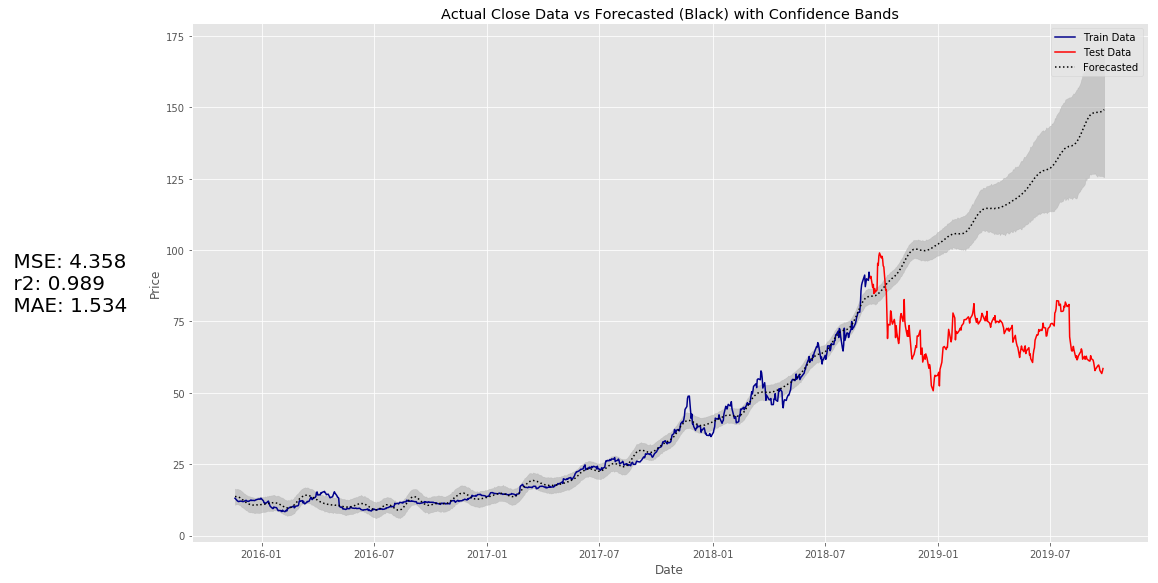

In [289]:
fig, ax1= plt.subplots()
ax1.plot(all_data.Close, color='darkblue')
ax1.plot(test_data.Close, color='red')
ax1.plot(all_data.yhat, color='black', linestyle=':')
ax1.fill_between(all_data.index, all_data['yhat_upper'], all_data['yhat_lower'], alpha=0.5, color='darkgray')
ax1.set_title('Actual Close Data vs Forecasted (Black) with Confidence Bands')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('Train Data')
L.get_texts()[1].set_text('Test Data')#change the legend text for 1st plot
L.get_texts()[2].set_text('Forecasted') #change the legend text for 2nd plot

textstr = f" MSE: {mse}\n r2: {r2}\n MAE: {mae}"
plt.text(0.01, 0.5, textstr, fontsize=20, transform=plt.gcf().transFigure)

fig.subplots_adjust(bottom=0.1, top=1, left=0.17, right=1)

<h1> Using all data for training </h1>

In [290]:
train_data_all = data

In [291]:
prophet_data2 = train_data_all.reset_index().rename(columns={'Date': 'ds','Close': 'y'})

In [292]:
#Initialize prophit object
pr2 = Prophet()

In [293]:
pr2.fit(prophet_data2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [294]:
future2 = pr2.make_future_dataframe(periods=380)

In [295]:
# Create a final future df without weekends
future_boolean = future2['ds'].map(isBusinessDay)
future2 = future2[future_boolean] 

In [296]:
#Make a prediction
forecast2 = pr2.predict(future2)

In [297]:
all_data2 = forecast2.set_index('ds').join(train_data_all).tail(3000)

In [298]:
all_data_drop_na = all_data2.dropna()
r2 = round(r2_score(all_data_drop_na.Close, all_data_drop_na.yhat), 3)

In [299]:
mse = round(mean_squared_error(all_data_drop_na.Close, all_data_drop_na.yhat), 3)

In [300]:
mae = round(mean_absolute_error(all_data_drop_na.Close, all_data_drop_na.yhat), 3)

Text(0.92, 0.5, ' MSE: 18.947\n r2: 0.972\n MAE: 3.177')

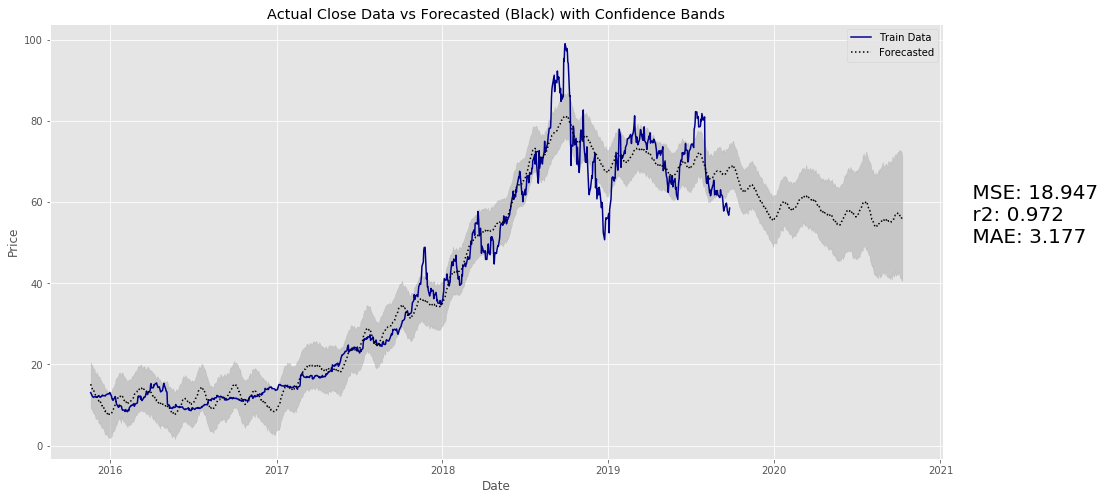

In [301]:
fig, ax1 = plt.subplots()
ax1.plot(all_data2.Close, color='darkblue')
ax1.plot(all_data2.yhat, color='black', linestyle=':')
ax1.fill_between(all_data2.index, all_data2['yhat_upper'], all_data2['yhat_lower'], alpha=0.5, color='darkgray')
ax1.set_title('Actual Close Data vs Forecasted (Black) with Confidence Bands')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('Train Data')
L.get_texts()[1].set_text('Forecasted') #change the legend text for 2nd plot

textstr = f" MSE: {mse}\n r2: {r2}\n MAE: {mae}"
plt.text(0.92, 0.5, textstr, fontsize=20, transform=plt.gcf().transFigure)

In [302]:
#Problem -> Statement of problem

In [ ]:
#Data -> Description of Data

In [ ]:
#EDA -> Explore: Find

In [ ]:
#Model -> Predict Models

In [ ]:
#What next -> Improve